이번 프로젝트에서는 작은 지역의 이미지 여러장을 통해 3D 지도를 만든다음에, 현재 알고싶은 이미지의 위치를 추정할 것입니다. 

필요한 Library들을 다운로드 받습니다. 
추가적으로 발생하는 requirement 설치 파일들을 설치해주세요.    
아래 Markdown 형태로 저장된 명령어를 통해 설치하셔도 됩니다.   
Pytorch의 경우 버전을 확인해주셔서 본인의 GPU와 호환되게 값을 변경해주세요.

In [46]:

%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


!conda install -n HFNet ipykernel --update-deps --force-reinstall  
!pip install tqdm  
!conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch  
!pip install h5py

# 설정
프로젝트 실행 중 output 결과를 저장할 경로를 설정하여 줍니다.

In [47]:
images = Path('datasets/광화문')
outputs = Path('outputs/광화문/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

# 3D mapping
데이터 베이스를 구성할 3D Point를 만들기 위한 이미지 데이터셋을 확인합니다.  
총 10장의 광화문 이미지입니다.

10 mapping images


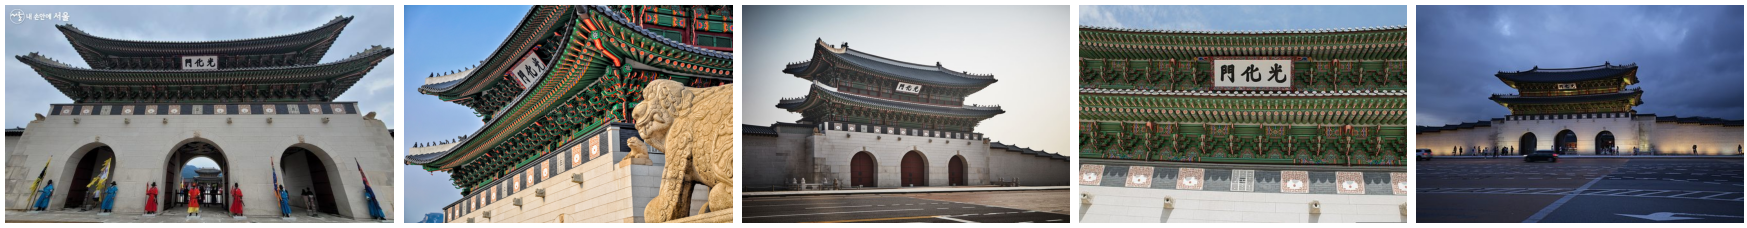

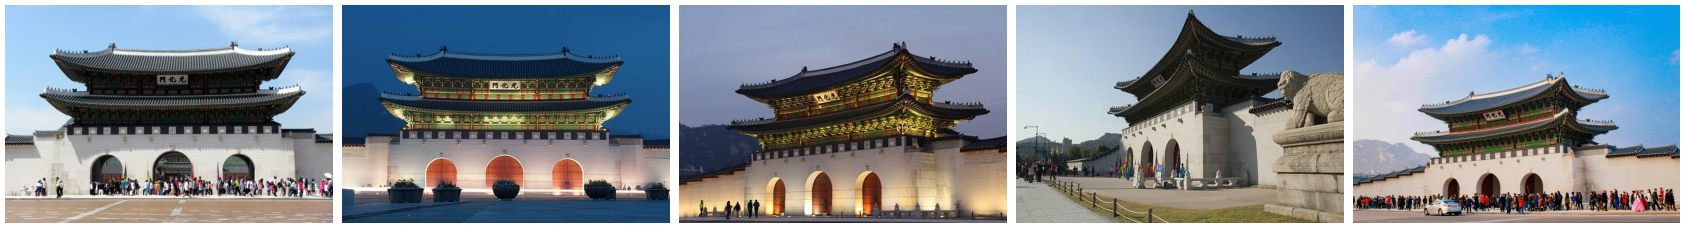

In [48]:
references = [p.relative_to(images).as_posix() for p in (images / 'mapping/').iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references[:5]], dpi=50)
plot_images([read_image(images / r) for r in references[5:10]], dpi=50)

각각의 이미지에서 SuperPoint Model을 통해서 특징을 추출하고 SuperFlue Model을 통해 이미지간의 특칭을 매칭합니다. 

In [49]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2022/11/20 15:09:34 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


[2022/11/20 15:09:34 hloc INFO] Finished exporting features.
[2022/11/20 15:09:34 hloc INFO] Found 45 pairs.
[2022/11/20 15:09:34 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}



Loaded SuperGlue model ("outdoor" weights)


[2022/11/20 15:09:38 hloc INFO] Finished exporting matches.


Structure-from-Motion을 통해서 3D Point를 구성합니다. 

In [50]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping")
fig.show()

[2022/11/20 15:09:38 hloc INFO] Creating an empty database...
[2022/11/20 15:09:38 hloc INFO] Importing images into the database...
[2022/11/20 15:09:38 hloc INFO] Importing features into the database...


[2022/11/20 15:09:38 hloc INFO] Importing matches into the database...


[2022/11/20 15:09:38 hloc INFO] Performing geometric verification of the matches...


[2022/11/20 15:09:39 hloc INFO] Running 3D reconstruction...
[2022/11/20 15:09:44 hloc INFO] Reconstructed 1 model(s).
[2022/11/20 15:09:44 hloc INFO] Largest model is #0 with 10 images.
[2022/11/20 15:09:44 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 10
	num_cameras = 10
	num_points3D = 1290
	num_observations = 4340
	mean_track_length = 3.36434
	mean_observations_per_image = 434
	mean_reprojection_error = 0.973029
	num_input_images = 10


어떤 특징점이 3D Map을 형성하는데 기여하였는지 확인할 수 있습니다. 
전체 특징점 중에서 파란색이 3D Point를 생성하는데 기여한 특징점 입니다.

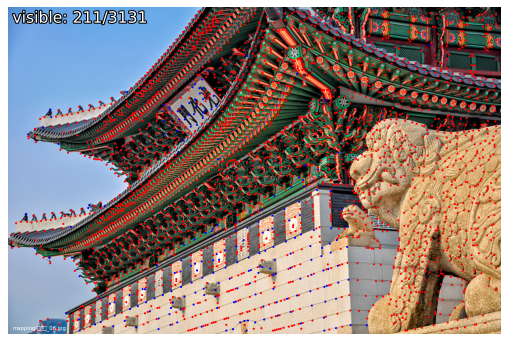

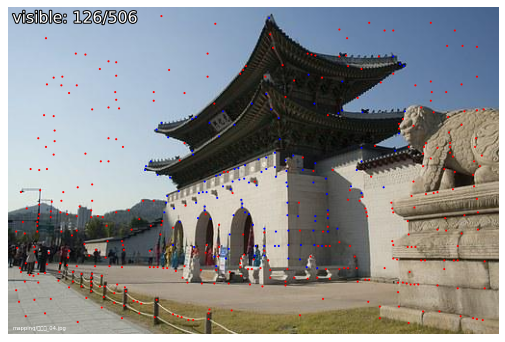

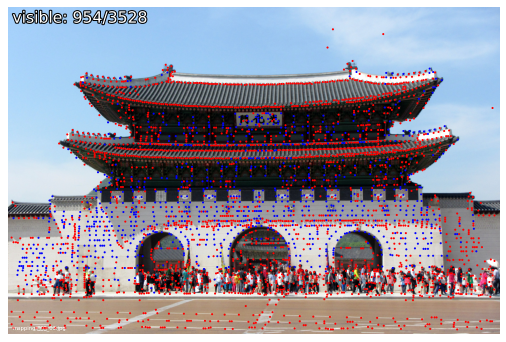

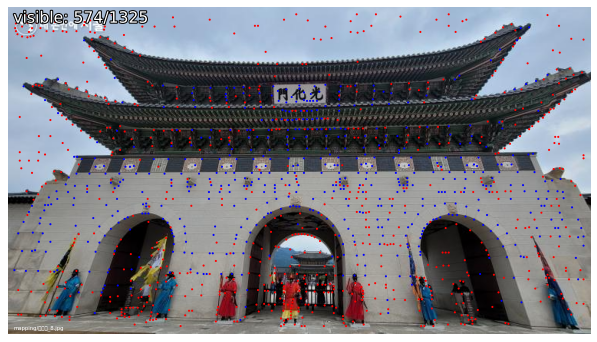

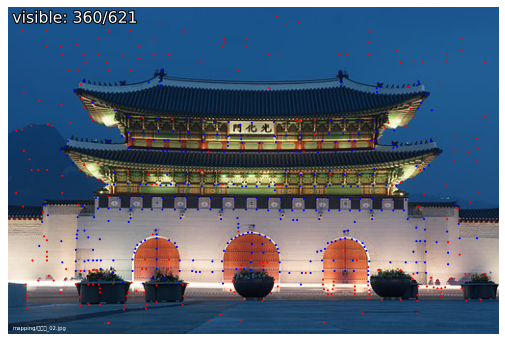

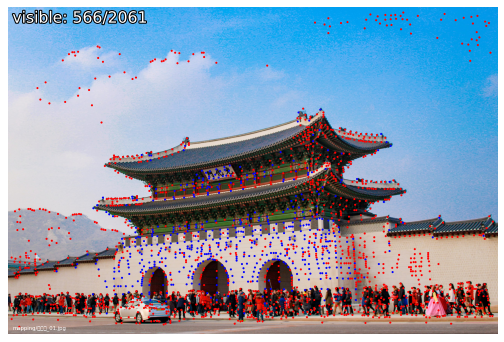

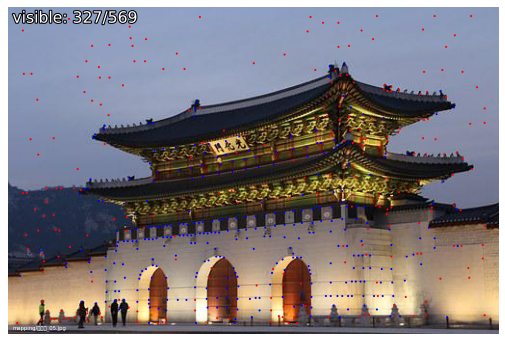

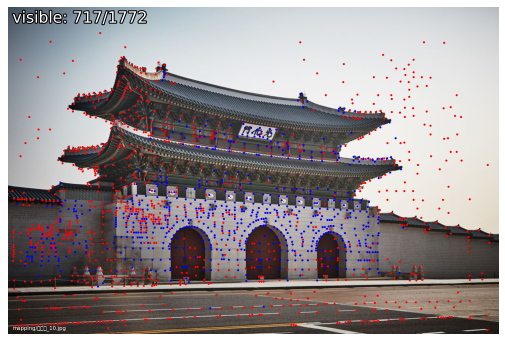

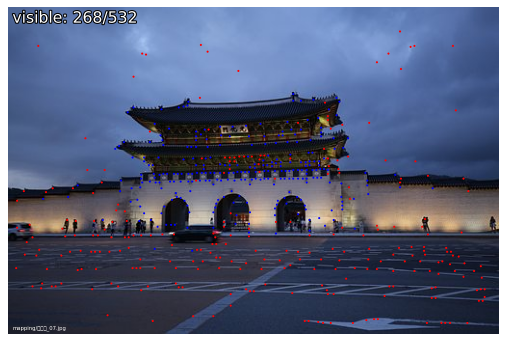

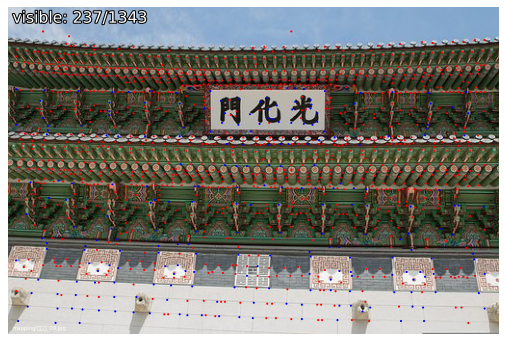

In [51]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=10)

# Localizatation
모든 데이터베이스를 구축하였습니다. 전체 이미지 데이터셋으로부터 특징점을 추출했고, 추출한 특징점들끼리 매칭한 뒤 3D Point를 생성하여 3D Map을 구성했습니다.  
이제, input으로 한장의 이미지가 들어오게되면 그 이미지의 위치와 방향을 추정할 것입니다.   
먼저 쿼리(추정할 이미지)이미지를 확인합니다.

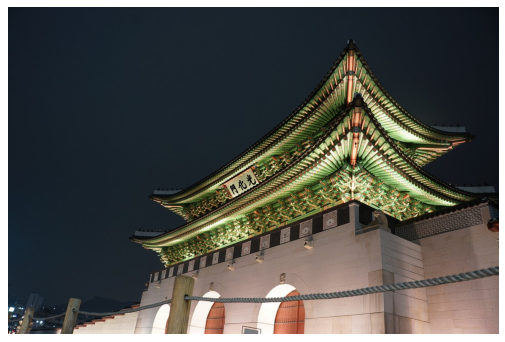

In [52]:
query = 'query/Query.jpg'
plot_images([read_image(images / query)], dpi=75)

쿼리 이미지의 특징점을 SuperPoint 모델을 통해 추출하고, SuperGlue 모델을 통해서 데이터베이스 이미지간의 특징점 매칭을 수행합니다. 

In [53]:
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

[2022/11/20 15:09:48 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


[2022/11/20 15:09:48 hloc INFO] Finished exporting features.
[2022/11/20 15:09:48 hloc INFO] Found 10 pairs.
[2022/11/20 15:09:48 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}



Loaded SuperGlue model ("outdoor" weights)


[2022/11/20 15:09:49 hloc INFO] Finished exporting matches.


전체 데이터베이스에 있는 이미지와 쿼리이미지간의 특징점 매칭을 수행한 결과를 시각화 합니다.   
그 후 PnP+RANSAC 기술을 사용하여 절대적인 카메라 포즈(위치와 방향)를 추정하게 됩니다.   
inliers 순으로 이미지를 시각화 할 수 있습니다.   
전체 특징점 중에서 매칭된 특징점 개수를 왼쪽 상단에서 보실 수 있습니다.  


found 298/637 inlier correspondences.


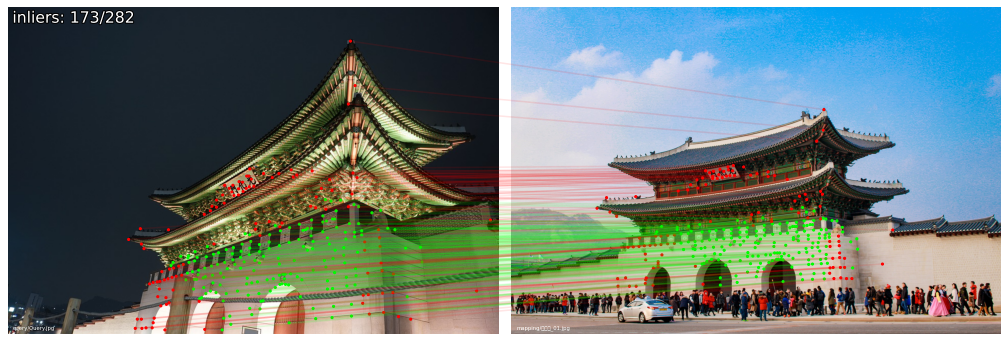

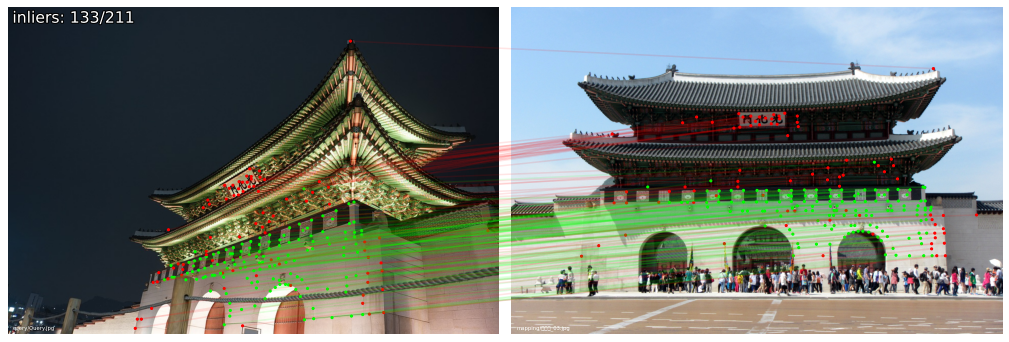

In [54]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r).image_id for r in references]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

이를 통해 3D Map을 통해서 추정된 쿼리 이미지의 카페라 포즈를 시각화하여 볼 수 있습니다.   
초록색으로 표시된 것이 쿼리 이미지의 위치와 방향을 나타냅니다.

In [55]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query)
fig.show()